In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers
import baukit
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from baukit import nethook
from operator import itemgetter
from relations.evaluate import evaluate
from relations.corner import CornerEstimator

In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float32)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 24320971760


In [4]:
corner_estimator = CornerEstimator(
    model = model, tokenizer = tokenizer, ln_f_name = mt.ln_f_name, unembedder_module_name = mt.unembedder_name
)

In [5]:
#################################################
relation = "{} is located in the country of"
relation_id = "P17"
precision_at = 3
#################################################

with open("../data/counterfact.json") as f:
    counterfact = json.load(f)

counterfact_filtered = [
    c['requested_rewrite'] for c in counterfact 
    if c["requested_rewrite"]['relation_id'] == relation_id
]
objects = [" "+ o['target_true']['str'] for o in counterfact_filtered]
objects = list(set(objects))
objects.append(" China")
print("unique objects: ", len(objects), objects[0:5])

unique objects:  96 [' Nepal', ' Colombia', ' Algeria', ' Tunisia', ' Taiwan']


In [6]:
target_token_ids = tokenizer(objects, padding=True, return_tensors="pt").to(model.device)
target_token_ids = target_token_ids.input_ids.view(len(objects))
target_token_ids.shape

torch.Size([96])

In [7]:
counterfact_filtered[0]

{'prompt': '{}, which is located in',
 'relation_id': 'P17',
 'target_new': {'str': 'Sweden', 'id': 'Q34'},
 'target_true': {'str': 'Spain', 'id': 'Q29'},
 'subject': 'Autonomous University of Madrid'}

In [8]:
from relations.evaluate import filter_correct_predictions_by_model

counterfact_gold = filter_correct_predictions_by_model(
    model, tokenizer,
    "{} is located in the country of",
    counterfact_filtered
)

100%|██████████| 875/875 [03:24<00:00,  4.28it/s]


In [83]:
batch_size = 20
cf_original = counterfact_gold[:batch_size]
cf_corrupted = []

for c_o in cf_original:
    perm = np.random.permutation(len(counterfact_gold))
    for i in perm:
        c_i = counterfact_gold[i]
        if(c_i['subject'] != c_o['subject'] and c_i['target_true']['str'] != c_o['target_true']['str']):
            cf_corrupted.append(c_i)
            break

In [84]:
for c_o, c_i in zip(cf_original, cf_corrupted):
    print(f"{c_o['subject']} <=> {c_i['subject']} <<<>>> {c_o['target_true']['str']} <=> {c_i['target_true']['str']}")

Autonomous University of Madrid <=> Kuomintang <<<>>> Spain <=> Taiwan
Kuala Langat <=> Santa Maria da Feira Municipality <<<>>> Malaysia <=> Portugal
Wanne-Eickel Central Station <=> Lodhran Tehsil <<<>>> Germany <=> Pakistan
Bastille <=> Gobind Sagar <<<>>> France <=> India
Shablykinsky District <=> Transylvanian Plateau <<<>>> Russia <=> Romania
Valdemarsvik <=> Warsaw Uprising Museum <<<>>> Sweden <=> Poland
Attingal <=> National Congress of Brasil <<<>>> India <=> Brazil
Nizampatnam <=> Santo Spirito in Sassia <<<>>> India <=> Italy
Darmstadt <=> 1931 Nicaragua earthquake <<<>>> Germany <=> Nicaragua
Adliswil <=> Perpignan <<<>>> Switzerland <=> France
Canada Live <=> Honnavar <<<>>> Canada <=> India
Knockmealdown Mountains <=> Ikuno-ku <<<>>> Ireland <=> Japan
Gazzola <=> Putyvl <<<>>> Italy <=> Ukraine
Borovsky District <=> Cairo American College <<<>>> Russia <=> Egypt
Kyoto University <=> Kahrizak <<<>>> Japan <=> Iran
HSBC Bank Malta <=> Cocconato <<<>>> Malta <=> Italy
Chu L

In [85]:
prompts_original_batch = [
    relation.format(cf['subject']) for cf in cf_original
]
subject_original_batch = [cf['subject'] for cf in cf_original]

batch_tokenized_o = tokenizer(prompts_original_batch, padding = True, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
offset_mapping = batch_tokenized_o.pop('offset_mapping')

In [86]:
subject_original_ranges = [
    estimate._find_token_range(string = prompt, substring = subject, offset_mapping = offset) 
    for prompt, subject, offset in zip(prompts_original_batch, subject_original_batch, offset_mapping)
]

In [87]:
prompts_corruption_batch = [
    relation.format(cf['subject']) for cf in cf_corrupted
]
subject_corruption_batch = [cf['subject'] for cf in cf_corrupted]

batch_tokenized_c = tokenizer(prompts_corruption_batch, padding = True, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
offset_mapping = batch_tokenized_c.pop('offset_mapping')

In [88]:
subject_corruption_ranges = [
    estimate._find_token_range(string = prompt, substring = subject, offset_mapping = offset) 
    for prompt, subject, offset in zip(prompts_corruption_batch, subject_corruption_batch, offset_mapping)
]

In [89]:
###################################################
intervention_layer = 15
###################################################

intervention_layer_name = mt.layer_name_format.format(15)

In [90]:
def collect_h_batch(
    model, tokenizer,
    prompt_batch, subject_ranges,
    intervention_layer_name
):
    h_batch = []
    for prompt, sub_range in zip(prompt_batch, subject_ranges):
        tokenized = tokenizer(prompt, return_tensors = "pt").to(model.device)
        with baukit.TraceDict(
            model, [intervention_layer_name]
        ) as traces:
            output = model(**tokenized)
        h = model_utils.untuple(traces[intervention_layer_name].output)[0][sub_range[1] - 1]
        h_batch.append(h)
#     print(len(h_batch))
    return torch.stack(h_batch, dim = 0)
        
h_original_batch = collect_h_batch(
    model, tokenizer,
    prompt_batch = [relation.format(cf['subject']) for cf in cf_original], 
    subject_ranges = subject_original_ranges,
    intervention_layer_name = mt.layer_name_format.format(intervention_layer)
)

h_corruption_batch = collect_h_batch(
    model, tokenizer,
    prompt_batch = [relation.format(cf['subject']) for cf in cf_corrupted], 
    subject_ranges = subject_corruption_ranges,
    intervention_layer_name = mt.layer_name_format.format(intervention_layer)
)

h_original_batch.shape, h_corruption_batch.shape

(torch.Size([20, 4096]), torch.Size([20, 4096]))

In [91]:
batch_tokenized_o.attention_mask.sum(dim = 1) - 1

tensor([10,  9, 13,  8, 10, 10,  8, 10,  8,  9,  7, 11,  8,  9,  8,  9, 11,  8,
         9, 10], device='cuda:0')

## Necessary subspace search

In [92]:
from typing import List

def interpret_model_output(output):
    token_ids = output.logits[0][-1].argsort()[-10:]
    logits = output.logits[0][-1][token_ids]
    proba = torch.nn.functional.softmax(output.logits[0][-1], dim = 0)[token_ids]

    return [
        (tokenizer.decode(t), l.item(), p.item()) for t, l, p in zip(token_ids, logits, proba)
    ][::-1]

def get_replace_intervention_batch(
    intervention_layer: str,
    intervention_indices: List[int],
    h_intervention: List[torch.tensor],
):
    def intervention(output, layer):
        if(layer != intervention_layer):
            return output
        for i in range(len(intervention_indices)):
            # replace the hidden state at `(t_pos[i])`th token of `i`th prompt with `h_intervention[i]` 
            output[0][i][intervention_indices[i]] = h_intervention[i]  
            
        return output
    
    return intervention

In [93]:
with baukit.TraceDict(
    model, [intervention_layer_name],
):
    output_o = model(**batch_tokenized_o)

In [94]:
answer_indices = batch_tokenized_o['attention_mask'].sum(dim = 1) - 1

In [95]:
def interpret_output_batch(logits, token_indices, top_k = 5):
    ret = []
    for cur_logit, t_idx in zip(logits, token_indices):
        token_ids = cur_logit[t_idx].argsort()[-top_k:]
        lgts = cur_logit[t_idx][token_ids]
        proba = torch.nn.functional.softmax(cur_logit[t_idx], dim = 0)[token_ids]
        ret.append([
            (tokenizer.decode(t), l.item(), p.item()) for t, l, p in zip(token_ids, lgts, proba)
        ][::-1])
    return ret

interpreted = interpret_output_batch(
    outputs_o.logits,
    token_indices = batch_tokenized_o['attention_mask'].sum(dim = 1) - 1,
    top_k = 5
)

for prompt, intr in zip(prompts_original_batch, interpreted):
    print(prompt, " ===> ", intr[0])

Autonomous University of Madrid is located in the country of  ===>  (' Spain', 16.377225875854492, 0.6641588807106018)
Kuala Langat is located in the country of  ===>  (' Malaysia', 18.25891876220703, 0.5825766324996948)
Wanne-Eickel Central Station is located in the country of  ===>  (' Germany', 15.945134162902832, 0.21043244004249573)
Bastille is located in the country of  ===>  (' France', 14.45266056060791, 0.2441401332616806)
Shablykinsky District is located in the country of  ===>  (' Russia', 15.651861190795898, 0.09798916429281235)
Valdemarsvik is located in the country of  ===>  (' Sweden', 15.790266990661621, 0.3024168014526367)
Attingal is located in the country of  ===>  (' India', 14.69201946258545, 0.1472671777009964)
Nizampatnam is located in the country of  ===>  (' India', 17.59539222717285, 0.4073825776576996)
Darmstadt is located in the country of  ===>  (' Germany', 16.2531681060791, 0.4313625693321228)
Adliswil is located in the country of  ===>  (' Switzerland', 

In [96]:
[rng[1] - 1 for rng in subject_original_ranges]

[4, 3, 7, 2, 4, 4, 2, 4, 2, 3, 1, 5, 2, 3, 2, 3, 5, 2, 3, 4]

In [97]:
target_distribution = []
for i in range(batch_size):
    a_idx = answer_indices[i]
    current_target = torch.nn.functional.log_softmax(output_o.logits[i][a_idx][target_token_ids], dim = 0)
    target_distribution.append(current_target)

target_distribution = torch.stack(target_distribution, dim = 0)
target_distribution.shape

torch.Size([20, 96])

In [98]:
def logits_to_distribution(logits, answer_indices, target_token_ids = None):
    p_distribution = []
    for i in range(logits.shape[0]):
        a_idx = answer_indices[i]
        current_target = torch.nn.functional.log_softmax(logits[i][a_idx][target_token_ids], dim = 0)
        p_distribution.append(current_target)

    return torch.stack(p_distribution, dim = 0)

p_distribution = logits_to_distribution(
    outputs_o.logits, 
    answer_indices = answer_indices,
    target_token_ids = target_token_ids
)

In [99]:
from torch.nn.functional import kl_div

kl_div(p_distribution, target_distribution, reduction = "batchmean", log_target = True)

tensor(0., device='cuda:0')

In [100]:
# predicted_distribution = []
# for idx in np.random.permutation(batch_size):
# #     print(idx)
#     predicted_distribution.append(target_distribution[idx])
# predicted_distribution = torch.stack(predicted_distribution, dim = 0)

In [101]:
###########################################################
num_basis = 100
intervention_layer = 10
##########################################################

intervention_layer_name = mt.layer_name_format.format(intervention_layer)

In [102]:
def make_subspace_normal(Q, num_epochs = 100, learning_rate = 0.001):
    normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
    print(f"initial loss => {normal_loss.item()}")
    
    Q.requires_grad = True
    optimizer = torch.optim.Adam([Q], lr = learning_rate)
    for epoch in tqdm(range(num_epochs)):
        subspace = Q @ Q.T
        normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
        optimizer.zero_grad()
        model.zero_grad()
        normal_loss.backward()
        optimizer.step()
    
    normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
    print(f"final loss => {normal_loss.item()}")
    return Q

initial loss => 16463.931640625


  0%|          | 0/300 [00:00<?, ?it/s]

final loss => 0.8146403431892395


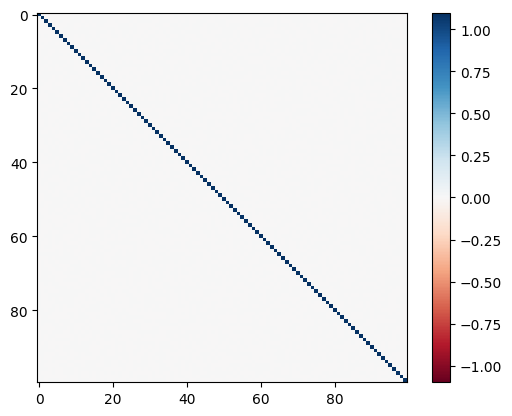

In [103]:
####################################
num_epochs = 3
learning_rate = 0.001
normal_lambda = 1
batch_size = 20
num_basis = 100
###################################

Q = torch.FloatTensor(mt.n_embd, num_basis).uniform_(-.1, .1).to(model.device)
Q.requires_grad = True

# Make Q normal before optimizing with KL
Q = make_subspace_normal(Q, num_epochs = 300)
from util import misc
misc.visualize_matrix((Q.T @ Q).detach().cpu())

In [104]:
optimizer = torch.optim.Adam([Q], lr = learning_rate)

num_epochs = 10
_lambda = 1

loss_track = []


for epoch in tqdm(range(num_epochs)):
    subspace = Q @ Q.T # <---- current subspace
    
    # build the h_intervention_batch
    I = torch.eye(mt.n_embd).to(model.dtype).to(model.device)
    h_intervention_batch = h_original_batch @ subspace + h_corruption_batch @ (I - subspace)
    
#     print(h_intervention_batch)
    
    with baukit.TraceDict(
        model, [intervention_layer_name],
        edit_output = get_replace_intervention_batch(
            intervention_layer = intervention_layer_name,
            intervention_indices = [rng[1] - 1 for rng in subject_original_ranges],
            h_intervention = h_intervention_batch
        )
    ) as traces_c:
        output_c = model(**batch_tokenized_o)
        
    predicted_distribution = logits_to_distribution(
        output_c.logits, 
        answer_indices = answer_indices,
        target_token_ids = target_token_ids
    )
    
    kl_loss = kl_div(predicted_distribution, target_distribution, reduction = "batchmean", log_target = True)
    normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()
    loss = kl_loss + _lambda * (normal_loss)
    
    print(f"Epoch >> {epoch + 1}: {kl_loss.item()} + {normal_loss.item()} = {loss.item()}")
    
    loss_track.append(loss.item())
    optimizer.zero_grad()
    model.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch >> 1: 2.3081982135772705 + 0.8146403431892395 = 3.1228384971618652
Epoch >> 2: 1.663977026939392 + 0.04700171947479248 = 1.7109787464141846
Epoch >> 3: 1.108739972114563 + 0.13523349165916443 = 1.2439734935760498
Epoch >> 4: 0.6280838847160339 + 0.28541964292526245 = 0.9135035276412964
Epoch >> 5: 0.37704241275787354 + 0.2700986862182617 = 0.6471410989761353
Epoch >> 6: 0.2880299985408783 + 0.144524484872818 = 0.4325544834136963
Epoch >> 7: 0.24129509925842285 + 0.05204859375953674 = 0.2933436930179596
Epoch >> 8: 0.19398348033428192 + 0.06960193812847137 = 0.2635854184627533
Epoch >> 9: 0.1471986323595047 + 0.1316547393798828 = 0.2788533568382263
Epoch >> 10: 0.10569434612989426 + 0.1403108537197113 = 0.24600520730018616


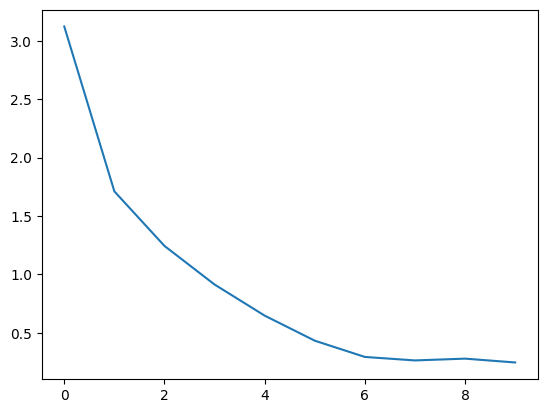

In [106]:
plt.plot(loss_track)

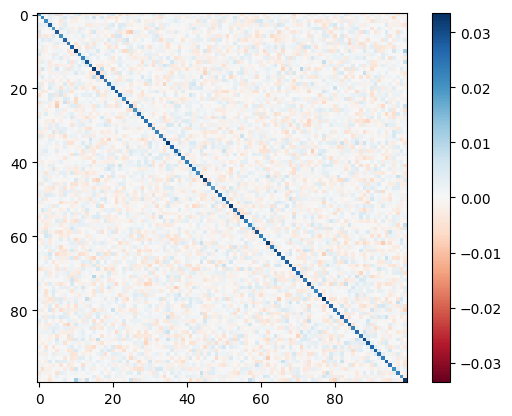

In [107]:
misc.visualize_matrix((Q @ Q.T).detach().cpu())

In [108]:
# interpreted = interpret_output_batch(
#     output_c.logits,
#     token_indices = answer_indices,
#     top_k = 5
# )

# for prompt, intr, corr in zip(prompts_original_batch, interpreted, cf_corrupted):
#     print(prompt, " ===> ", intr[0], "<<>>", corr["target_true"]["str"])

initial loss => 16491.90234375


  0%|          | 0/300 [00:00<?, ?it/s]

final loss => 0.8169213533401489


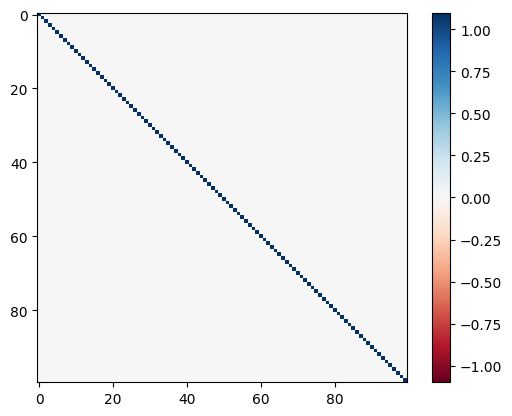

In [295]:
####################################
num_basis = 100
intervention_layer = 15
# ---------------------------------
num_epochs = 10
batch_size = 20
learning_rate = 0.001
normal_lambda = 1
###################################

Q = torch.FloatTensor(mt.n_embd, num_basis).uniform_(-.1, .1).to(model.device)
Q.requires_grad = True

# Make Q normal before optimizing with KL
Q = make_subspace_normal(Q, num_epochs = 300)
from util import misc
misc.visualize_matrix((Q.T @ Q).detach().cpu())

In [296]:
loss_track = []
optimizer = torch.optim.Adam([Q], lr = learning_rate)


initial = True
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch >> {epoch + 1}")
    
    for batch_st in tqdm(range(0, len(counterfact_gold), batch_size)):
        
        # building the current gold batch
        batch_nd = min(batch_st + batch_size, len(counterfact_gold))
        cf_original = counterfact_gold[batch_st : batch_nd]
        
        prompts_original_batch = [relation.format(cf['subject']) for cf in cf_original]
        subject_original_batch = [cf['subject'] for cf in cf_original]
        batch_tokenized_o = tokenizer(prompts_original_batch, padding = True, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
        offset_mapping = batch_tokenized_o.pop('offset_mapping')
        subject_original_ranges = [
            estimate._find_token_range(string = prompt, substring = subject, offset_mapping = offset) 
            for prompt, subject, offset in zip(prompts_original_batch, subject_original_batch, offset_mapping)
        ]
        
        # collect the gold `h_o`
        h_original_batch = collect_h_batch(
            model, tokenizer,
            prompt_batch = prompts_original_batch, 
            subject_ranges = subject_original_ranges,
            intervention_layer_name = mt.layer_name_format.format(intervention_layer)
        )
        
        for iteration in range(3):
            
            # collecting the corruption 
            cf_corrupted = []
            for c_o in cf_original:
                perm = np.random.permutation(len(counterfact_gold))
                for idx in perm:
                    c_i = counterfact_gold[idx]
                    if(c_i['subject'] != c_o['subject'] and c_i['target_true']['str'] != c_o['target_true']['str']):
                        cf_corrupted.append(c_i)
                        break
            
            prompts_corruption_batch = [relation.format(cf['subject']) for cf in cf_corrupted]
            subject_corruption_batch = [cf['subject'] for cf in cf_corrupted]
            batch_tokenized_c = tokenizer(prompts_corruption_batch, padding = True, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
            offset_mapping = batch_tokenized_c.pop('offset_mapping')
            subject_corruption_ranges = [
                estimate._find_token_range(string = prompt, substring = subject, offset_mapping = offset) 
                for prompt, subject, offset in zip(prompts_corruption_batch, subject_corruption_batch, offset_mapping)
            ]
            
            # collecting respective h_c
            h_corruption_batch = collect_h_batch(
                model, tokenizer,
                prompt_batch = prompts_corruption_batch, 
                subject_ranges = subject_corruption_ranges,
                intervention_layer_name = mt.layer_name_format.format(intervention_layer)
            )
            
            subspace = Q @ Q.T # <---- current subspace
            
            # build the h_intervention_batch
            I = torch.eye(mt.n_embd).to(model.dtype).to(model.device)
            h_intervention_batch = h_original_batch @ subspace + h_corruption_batch @ (I - subspace)
#             h_corruption_mean = h_corruption_batch.mean(dim = 0)
#             h_intervention_batch = h_original_batch @ subspace + h_corruption_mean @ (I - subspace)

            # run the prompts as usual to collect target distribution
            with baukit.TraceDict(
                model, [intervention_layer_name],
            ):
                output_o = model(**batch_tokenized_o)
            answer_indices = batch_tokenized_o['attention_mask'].sum(dim = 1) - 1

            target_distribution = logits_to_distribution(
                output_o.logits, 
                answer_indices = answer_indices,
                target_token_ids = target_token_ids
            )

            # run with corrupted hidden representations
            with baukit.TraceDict(
                model, [intervention_layer_name],
                edit_output = get_replace_intervention_batch(
                    intervention_layer = intervention_layer_name,
                    intervention_indices = [rng[1] - 1 for rng in subject_original_ranges],
                    h_intervention = h_intervention_batch
                )
            ) as traces_c:
                output_c = model(**batch_tokenized_o)

            predicted_distribution = logits_to_distribution(
                output_c.logits, 
                answer_indices = answer_indices,
                target_token_ids = target_token_ids
            )


            kl_loss = kl_div(predicted_distribution, target_distribution, reduction = "batchmean", log_target = True)
            normal_loss = (torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()

            loss = kl_loss + _lambda * (normal_loss)

            print(f"{batch_st} -- {batch_nd} >>> {iteration} >>> {kl_loss.item()} + {normal_loss.item()} = {loss.item()}")

            loss_track.append(loss.item())
            optimizer.zero_grad()
            model.zero_grad()
            loss.backward()
            optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch >> 1


  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 2.1687259674072266 + 0.8169213533401489 = 2.985647201538086
0 -- 20 >>> 1 >>> 2.2874398231506348 + 0.04187893867492676 = 2.3293187618255615
0 -- 20 >>> 2 >>> 3.2126424312591553 + 0.14425718784332275 = 3.3568997383117676
20 -- 40 >>> 0 >>> 1.573833703994751 + 0.3197263181209564 = 1.8935600519180298
20 -- 40 >>> 1 >>> 1.1488945484161377 + 0.32675451040267944 = 1.475649118423462
20 -- 40 >>> 2 >>> 1.0662487745285034 + 0.2189432680606842 = 1.2851920127868652
40 -- 60 >>> 0 >>> 2.274876356124878 + 0.13666099309921265 = 2.4115374088287354
40 -- 60 >>> 1 >>> 1.9454469680786133 + 0.1333680897951126 = 2.07881498336792
40 -- 60 >>> 2 >>> 0.9601961374282837 + 0.20552504062652588 = 1.1657211780548096
60 -- 80 >>> 0 >>> 1.3725117444992065 + 0.2844730317592621 = 1.656984806060791
60 -- 80 >>> 1 >>> 0.89629727602005 + 0.3245311677455902 = 1.2208284139633179
60 -- 80 >>> 2 >>> 1.4635798931121826 + 0.2918544113636017 = 1.755434274673462
80 -- 100 >>> 0 >>> 0.6228140592575073 + 0.24143

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.16500291228294373 + 0.07193751633167267 = 0.2369404286146164
0 -- 20 >>> 1 >>> 0.18974126875400543 + 0.0787416398525238 = 0.26848292350769043
0 -- 20 >>> 2 >>> 0.21060870587825775 + 0.07709890604019165 = 0.2877076268196106
20 -- 40 >>> 0 >>> 0.13378457725048065 + 0.06756149977445602 = 0.20134606957435608
20 -- 40 >>> 1 >>> 0.16633272171020508 + 0.054059334099292755 = 0.22039204835891724
20 -- 40 >>> 2 >>> 0.07642950862646103 + 0.042243823409080505 = 0.11867333203554153
40 -- 60 >>> 0 >>> 0.28603145480155945 + 0.03634743019938469 = 0.32237887382507324
40 -- 60 >>> 1 >>> 0.17950566112995148 + 0.035888805985450745 = 0.21539446711540222
40 -- 60 >>> 2 >>> 0.20610284805297852 + 0.04218664765357971 = 0.24828949570655823
60 -- 80 >>> 0 >>> 0.29052719473838806 + 0.051265649497509 = 0.34179285168647766
60 -- 80 >>> 1 >>> 0.20941738784313202 + 0.05436266213655472 = 0.26378005743026733
60 -- 80 >>> 2 >>> 0.22515983879566193 + 0.05059148371219635 = 0.2757513225078583
80 -- 100 

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.2781948447227478 + 0.015070983208715916 = 0.29326581954956055
0 -- 20 >>> 1 >>> 0.07675596326589584 + 0.014939351007342339 = 0.09169531613588333
0 -- 20 >>> 2 >>> 0.05080823227763176 + 0.013782674446702003 = 0.06459090858697891
20 -- 40 >>> 0 >>> 0.08838646858930588 + 0.012129159644246101 = 0.10051562637090683
20 -- 40 >>> 1 >>> 0.0718044638633728 + 0.011247796937823296 = 0.08305226266384125
20 -- 40 >>> 2 >>> 0.07040231674909592 + 0.01091410405933857 = 0.08131641894578934
40 -- 60 >>> 0 >>> 0.06164732202887535 + 0.010230985470116138 = 0.07187830656766891
40 -- 60 >>> 1 >>> 0.0961543545126915 + 0.009859234094619751 = 0.10601358860731125
40 -- 60 >>> 2 >>> 0.05713862180709839 + 0.010013435035943985 = 0.06715205311775208
60 -- 80 >>> 0 >>> 0.16704435646533966 + 0.01007150299847126 = 0.17711585760116577
60 -- 80 >>> 1 >>> 0.17715142667293549 + 0.010498283430933952 = 0.1876497119665146
60 -- 80 >>> 2 >>> 0.10843169689178467 + 0.013984059914946556 = 0.12241575866937637
8

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.033047545701265335 + 0.020439092069864273 = 0.05348663777112961
0 -- 20 >>> 1 >>> 0.03024229407310486 + 0.02031966857612133 = 0.05056196451187134
0 -- 20 >>> 2 >>> 0.03555986285209656 + 0.01635502278804779 = 0.05191488564014435
20 -- 40 >>> 0 >>> 0.06564550846815109 + 0.011448552832007408 = 0.07709406316280365
20 -- 40 >>> 1 >>> 0.07066822797060013 + 0.009340653195977211 = 0.08000887930393219
20 -- 40 >>> 2 >>> 0.052329182624816895 + 0.011351280845701694 = 0.06368046253919601
40 -- 60 >>> 0 >>> 0.0788470134139061 + 0.013664307072758675 = 0.09251131862401962
40 -- 60 >>> 1 >>> 0.06258632242679596 + 0.015099678188562393 = 0.07768599689006805
40 -- 60 >>> 2 >>> 0.06082484871149063 + 0.014057468622922897 = 0.07488231360912323
60 -- 80 >>> 0 >>> 0.07675722986459732 + 0.01196986623108387 = 0.08872709423303604
60 -- 80 >>> 1 >>> 0.13312049210071564 + 0.009719457477331161 = 0.1428399533033371
60 -- 80 >>> 2 >>> 0.07728233188390732 + 0.012223211117088795 = 0.0895055457949638

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.06277339905500412 + 0.036437951028347015 = 0.09921135008335114
0 -- 20 >>> 1 >>> 0.052971601486206055 + 0.04016704857349396 = 0.09313865005970001
0 -- 20 >>> 2 >>> 0.04654916748404503 + 0.03059232234954834 = 0.07714149355888367
20 -- 40 >>> 0 >>> 0.09827093034982681 + 0.01803499460220337 = 0.11630592495203018
20 -- 40 >>> 1 >>> 0.056122418493032455 + 0.014472970739006996 = 0.0705953910946846
20 -- 40 >>> 2 >>> 0.04574600234627724 + 0.021375706419348717 = 0.0671217069029808
40 -- 60 >>> 0 >>> 0.07297094911336899 + 0.027719641104340553 = 0.10069058835506439
40 -- 60 >>> 1 >>> 0.09198125451803207 + 0.02639945223927498 = 0.11838071048259735
40 -- 60 >>> 2 >>> 0.06984157860279083 + 0.020293530076742172 = 0.0901351124048233
60 -- 80 >>> 0 >>> 0.13493794202804565 + 0.015485532581806183 = 0.15042346715927124
60 -- 80 >>> 1 >>> 0.13593311607837677 + 0.015189392492175102 = 0.15112251043319702
60 -- 80 >>> 2 >>> 0.1488758772611618 + 0.018982388079166412 = 0.1678582727909088
80

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.04885914921760559 + 0.02480287104845047 = 0.07366202026605606
0 -- 20 >>> 1 >>> 0.07706653326749802 + 0.02294115722179413 = 0.10000769048929214
0 -- 20 >>> 2 >>> 0.06525402516126633 + 0.01674044132232666 = 0.08199446648359299
20 -- 40 >>> 0 >>> 0.103826142847538 + 0.019018232822418213 = 0.12284437566995621
20 -- 40 >>> 1 >>> 0.09355484694242477 + 0.026771940290927887 = 0.12032678723335266
20 -- 40 >>> 2 >>> 0.04638583958148956 + 0.03545954078435898 = 0.08184538036584854
40 -- 60 >>> 0 >>> 0.06067204475402832 + 0.03289839252829552 = 0.09357044100761414
40 -- 60 >>> 1 >>> 0.04332861304283142 + 0.02256776951253414 = 0.06589638441801071
40 -- 60 >>> 2 >>> 0.06322934478521347 + 0.015413956716656685 = 0.078643299639225
60 -- 80 >>> 0 >>> 0.11474142223596573 + 0.015303108841180801 = 0.13004453480243683
60 -- 80 >>> 1 >>> 0.09411491453647614 + 0.019171584397554398 = 0.11328649520874023
60 -- 80 >>> 2 >>> 0.08971373736858368 + 0.023066826164722443 = 0.11278056353330612
80 --

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.05214039236307144 + 0.061670731753110886 = 0.11381112039089203
0 -- 20 >>> 1 >>> 0.05245247110724449 + 0.05692169815301895 = 0.10937416553497314
0 -- 20 >>> 2 >>> 0.048820171505212784 + 0.032137371599674225 = 0.08095754683017731
20 -- 40 >>> 0 >>> 0.09023349732160568 + 0.015549317002296448 = 0.10578281432390213
20 -- 40 >>> 1 >>> 0.05247325822710991 + 0.021502608433365822 = 0.07397586852312088
20 -- 40 >>> 2 >>> 0.04573642835021019 + 0.0361117348074913 = 0.0818481594324112
40 -- 60 >>> 0 >>> 0.061679907143116 + 0.040149420499801636 = 0.10182932764291763
40 -- 60 >>> 1 >>> 0.07881315797567368 + 0.029965892434120178 = 0.10877905040979385
40 -- 60 >>> 2 >>> 0.08077501505613327 + 0.02162359096109867 = 0.10239860415458679
60 -- 80 >>> 0 >>> 0.14455600082874298 + 0.024616463109850883 = 0.169172465801239
60 -- 80 >>> 1 >>> 0.1678718775510788 + 0.0331934355199337 = 0.2010653167963028
60 -- 80 >>> 2 >>> 0.1356261521577835 + 0.03761554881930351 = 0.17324170470237732
80 -- 100

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.06810852885246277 + 0.03959958255290985 = 0.10770811140537262
0 -- 20 >>> 1 >>> 0.044638630002737045 + 0.03618095815181732 = 0.08081959187984467
0 -- 20 >>> 2 >>> 0.038530148565769196 + 0.024323206394910812 = 0.06285335123538971
20 -- 40 >>> 0 >>> 0.09268247336149216 + 0.01650644838809967 = 0.10918892174959183
20 -- 40 >>> 1 >>> 0.04667101427912712 + 0.019217567518353462 = 0.06588858366012573
20 -- 40 >>> 2 >>> 0.04739084467291832 + 0.0292412880808115 = 0.07663213461637497
40 -- 60 >>> 0 >>> 0.07927384227514267 + 0.033027034252882004 = 0.11230087280273438
40 -- 60 >>> 1 >>> 0.06443046778440475 + 0.026401855051517487 = 0.09083232283592224
40 -- 60 >>> 2 >>> 0.05121487379074097 + 0.018397752195596695 = 0.06961262226104736
60 -- 80 >>> 0 >>> 0.12261765450239182 + 0.016115307807922363 = 0.13873296976089478
60 -- 80 >>> 1 >>> 0.1171698197722435 + 0.02218007668852806 = 0.13934989273548126
60 -- 80 >>> 2 >>> 0.09550736844539642 + 0.0305611714720726 = 0.12606853246688843
80

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.03691767156124115 + 0.07171300053596497 = 0.10863067209720612
0 -- 20 >>> 1 >>> 0.04630070552229881 + 0.05561693757772446 = 0.10191763937473297
0 -- 20 >>> 2 >>> 0.06173310428857803 + 0.027793101966381073 = 0.0895262062549591
20 -- 40 >>> 0 >>> 0.0432591550052166 + 0.018879307433962822 = 0.06213846057653427
20 -- 40 >>> 1 >>> 0.07487279921770096 + 0.02745044231414795 = 0.10232324153184891
20 -- 40 >>> 2 >>> 0.04927125573158264 + 0.03551103174686432 = 0.08478228747844696
40 -- 60 >>> 0 >>> 0.05243469402194023 + 0.03283396363258362 = 0.08526866137981415
40 -- 60 >>> 1 >>> 0.06723880767822266 + 0.023393267765641212 = 0.09063207358121872
40 -- 60 >>> 2 >>> 0.047060295939445496 + 0.01542800571769476 = 0.06248830258846283
60 -- 80 >>> 0 >>> 0.11494213342666626 + 0.015404293313622475 = 0.13034643232822418
60 -- 80 >>> 1 >>> 0.23009763658046722 + 0.021748818457126617 = 0.25184646248817444
60 -- 80 >>> 2 >>> 0.07679100334644318 + 0.03159046545624733 = 0.10838146507740021
80 

  0%|          | 0/21 [00:00<?, ?it/s]

0 -- 20 >>> 0 >>> 0.03676675632596016 + 0.01324138231575489 = 0.0500081405043602
0 -- 20 >>> 1 >>> 0.04152536019682884 + 0.011224089190363884 = 0.05274944752454758
0 -- 20 >>> 2 >>> 0.031115621328353882 + 0.009182637557387352 = 0.04029826074838638
20 -- 40 >>> 0 >>> 0.05340280756354332 + 0.008948520757257938 = 0.062351327389478683
20 -- 40 >>> 1 >>> 0.04194124415516853 + 0.009481247514486313 = 0.051422491669654846
20 -- 40 >>> 2 >>> 0.04967833682894707 + 0.010201485827565193 = 0.05987982451915741
40 -- 60 >>> 0 >>> 0.06840737909078598 + 0.010765337385237217 = 0.07917271554470062
40 -- 60 >>> 1 >>> 0.0650271400809288 + 0.010963029228150845 = 0.07599017024040222
40 -- 60 >>> 2 >>> 0.04778575524687767 + 0.012250986881554127 = 0.06003674119710922
60 -- 80 >>> 0 >>> 0.0691315084695816 + 0.01458829641342163 = 0.08371980488300323
60 -- 80 >>> 1 >>> 0.09011819213628769 + 0.01474799681454897 = 0.10486619174480438
60 -- 80 >>> 2 >>> 0.0746784582734108 + 0.014746077358722687 = 0.08942453563213348

In [297]:
(torch.eye(num_basis).to(model.dtype).to(model.device) - Q.T @ Q).square().sum()

tensor(0.0281, device='cuda:0', grad_fn=<SumBackward0>)

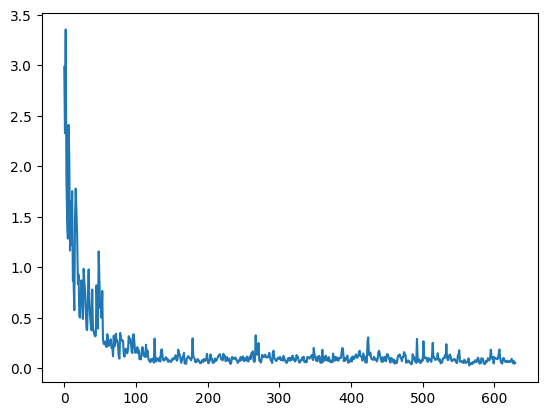

In [298]:
import matplotlib.pyplot as plt

plt.plot(loss_track)

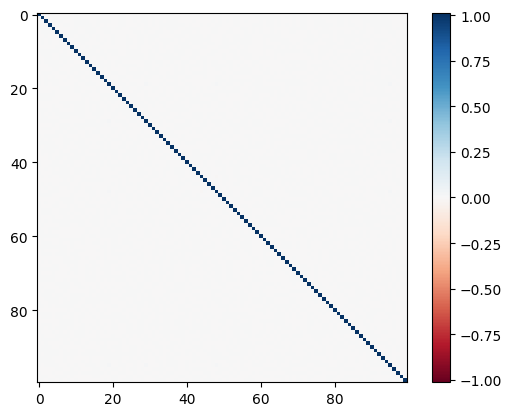

In [299]:
from util import misc

misc.visualize_matrix((Q.T @ Q).detach().cpu())

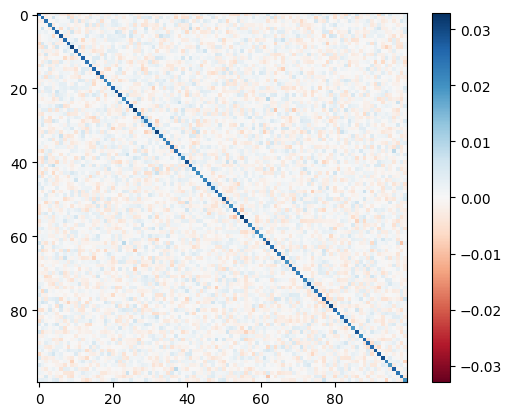

In [300]:
misc.visualize_matrix((Q @ Q.T).detach().cpu())

## Check Effect

In [301]:
perm = np.random.permutation(len(counterfact_gold))

cf_original = [counterfact_gold[p] for p in perm[:batch_size]]

cf_corrupted = []
for c_o in cf_original:
    perm = np.random.permutation(len(counterfact_gold))
    for i in perm:
        c_i = counterfact_gold[i]
        if(c_i['subject'] != c_o['subject'] and c_i['target_true']['str'] != c_o['target_true']['str']):
            cf_corrupted.append(c_i)
            break

In [302]:
for c_o, c_i in zip(cf_original, cf_corrupted):
    print(f"{c_o['subject']}, {c_o['target_true']['str']} <<<>>> {c_i['subject']}, {c_i['target_true']['str']}")

Colombes, France <<<>>> Nova Friburgo, Brazil
Maybach, Germany <<<>>> Circuit des Ardennes, Belgium
Cocconato, Italy <<<>>> Atromitos Piraeus F.C., Greece
Bolpur, India <<<>>> Taranto Sport, Italy
Emscher, Germany <<<>>> Dundalk, Ireland
Harnaut, India <<<>>> Lewin Brzeski, Poland
Southern Savonia, Finland <<<>>> Mukkam, India
Lajran Rural District, Iran <<<>>> Borghetto di Vara, Italy
K.S.V. Roeselare, Belgium <<<>>> Saint-Jacques-de-la-Lande, France
National Congress of Brasil, Brazil <<<>>> Southern Savonia, Finland
Sydney Hospital, Australia <<<>>> Adliswil, Switzerland
Jiul de Vest River, Romania <<<>>> Wismar, Germany
Mbale District, Uganda <<<>>> Bilecik Province, Turkey
FC Anker Wismar, Germany <<<>>> Borovsky District, Russia
Japan National Route 112, Japan <<<>>> Turkey national rugby union team, Turkey
Attingal, India <<<>>> Saint-Louis-de-Kent, New Brunswick, Canada
Gazzola, Italy <<<>>> Dornbirn, Austria
Pesisir Selatan, Indonesia <<<>>> Hammarby IF DFF, Sweden
Legnica Cou

In [303]:
# collect the gold `h_o` and corruption `h_c` 
prompts_original_batch = [relation.format(cf['subject']) for cf in cf_original]
subject_original_batch = [cf['subject'] for cf in cf_original]
batch_tokenized_o = tokenizer(prompts_original_batch, padding = True, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
offset_mapping = batch_tokenized_o.pop('offset_mapping')
subject_original_ranges = [
    estimate._find_token_range(string = prompt, substring = subject, offset_mapping = offset) 
    for prompt, subject, offset in zip(prompts_original_batch, subject_original_batch, offset_mapping)
]
        
prompts_corruption_batch = [relation.format(cf['subject']) for cf in cf_corrupted]
subject_corruption_batch = [cf['subject'] for cf in cf_corrupted]
batch_tokenized_c = tokenizer(prompts_corruption_batch, padding = True, return_tensors = "pt", return_offsets_mapping = True).to(model.device)
offset_mapping = batch_tokenized_c.pop('offset_mapping')
subject_corruption_ranges = [
    estimate._find_token_range(string = prompt, substring = subject, offset_mapping = offset) 
    for prompt, subject, offset in zip(prompts_corruption_batch, subject_corruption_batch, offset_mapping)
]

In [304]:
h_original_batch = collect_h_batch(
    model, tokenizer,
    prompt_batch = prompts_original_batch, 
    subject_ranges = subject_original_ranges,
    intervention_layer_name = mt.layer_name_format.format(intervention_layer)
)

h_corruption_batch = collect_h_batch(
    model, tokenizer,
    prompt_batch = prompts_corruption_batch, 
    subject_ranges = subject_corruption_ranges,
    intervention_layer_name = mt.layer_name_format.format(intervention_layer)
)

In [305]:
h_intervention_batch = h_original_batch @ subspace + h_corruption_batch @ (I - subspace)
# h_corruption_mean = h_corruption_batch.mean(dim = 0)
# h_intervention_batch = h_original_batch @ subspace + h_corruption_mean @ (I - subspace)

h_intervention_batch.shape

torch.Size([20, 4096])

In [308]:
subspace = Q @ Q.T
h_intervention_batch = h_original_batch @ subspace # + h_corruption_batch @ (I - subspace)
# h_intervention_batch = h_original_batch @ subspace + h_corruption_mean @ (I - subspace)

with baukit.TraceDict(
    model, [intervention_layer_name],
    edit_output = get_replace_intervention_batch(
        intervention_layer = intervention_layer_name,
        intervention_indices = [rng[1] - 1 for rng in subject_original_ranges],
        h_intervention = h_intervention_batch
    )
):
    output_o = model(**batch_tokenized_o)

interpreted = interpret_output_batch(
    output_o.logits,
    token_indices = batch_tokenized_o['attention_mask'].sum(dim = 1) - 1,
    top_k = 5
)

for prompt, intr in zip(prompts_original_batch, interpreted):
    print(prompt, " ===> ", intr[0])

Colombes is located in the country of  ===>  (' Colombia', 13.521454811096191, 0.08089239150285721)
Maybach is located in the country of  ===>  (' the', 12.679513931274414, 0.047018326818943024)
Cocconato is located in the country of  ===>  (' the', 12.923079490661621, 0.06715359538793564)
Bolpur is located in the country of  ===>  (' India', 13.554283142089844, 0.05072493851184845)
Emscher is located in the country of  ===>  (' Germany', 13.52907657623291, 0.09576839208602905)
Harnaut is located in the country of  ===>  (' the', 13.400875091552734, 0.06942175328731537)
Southern Savonia is located in the country of  ===>  (' the', 13.241996765136719, 0.07206452637910843)
Lajran Rural District is located in the country of  ===>  (' Iran', 14.478758811950684, 0.08481581509113312)
K.S.V. Roeselare is located in the country of  ===>  (' the', 14.381155014038086, 0.1056300550699234)
National Congress of Brasil is located in the country of  ===>  (' Brazil', 13.87472152709961, 0.169838130474

In [309]:
# h = torch.randn(mt.n_embd).to(model.device)
# torch.dist((h@subspace)[None].T, subspace @ h[None].T)

## Check on a Relation

In [310]:
def get_averaged_JB(top_performers, relation_prompt, subspace = None, num_icl = 3, calculate_at_lnf = False):
    try:
        jbs = []
        for s, s_idx, o in tqdm(top_performers):
            others = set(top_performers) - {(s, s_idx, o)}
            others = random.sample(list(others), k = min(num_icl, len(list(others)))) 
            prompt = ""
            prompt += "\n".join(relation_prompt.format(s_other) + f" {o_other}." for s_other, idx_other, o_other in others) + "\n"
            prompt += relation_prompt
            print("subject: ", s)
            print(prompt)

            jb, _ = estimate.relation_operator_from_sample(
                model, tokenizer,
                s, prompt,
                subject_token_index= s_idx,
                layer = 15,
                device = model.device,
                subspace = subspace
                # calculate_at_lnf = calculate_at_lnf,
                # layer_name_format = "model.decoder.layers.{}",
                # ln_f_name = "model.decoder.final_layer_norm",
                # n_layer_field = "num_hidden_layers"
            )
            print(jb.weight.norm(), jb.bias.norm())
            print()
            jbs.append(jb)
        
        weight = torch.stack([jb.weight for jb in jbs]).mean(dim=0)
        bias  = torch.stack([jb.bias for jb in jbs]).mean(dim=0)

        return weight, bias
    except RuntimeError as e:
        if(str(e).startswith("CUDA out of memory")):
            print("CUDA out of memory")
        if(num_icl > 1):
            num_icl -= 1
            print("trying with smaller icl >> ", num_icl)
            return get_averaged_JB(top_performers, relation_prompt, num_icl, calculate_at_lnf)
        else:
            raise Exception("RuntimeError >> can't calculate Jacobian with minimum number of icl examples")

def get_multiple_averaged_JB(top_performers, relation_prompt, subspace = None, N = 3, num_icl = 2, calculate_at_lnf = False):
    weights_and_biases = []
    sample_size = min(len(top_performers), num_icl + 2)
    for _ in tqdm(range(N)):
        cur_sample = random.sample(top_performers, k = sample_size)
        weight, bias = get_averaged_JB(cur_sample, relation_prompt, subspace, num_icl, calculate_at_lnf)
        weights_and_biases.append({
            'weight': weight,
            'bias'  : bias
        })
    return weights_and_biases

In [311]:
relation

'{} is located in the country of'

In [312]:
samples = [
    ("The Great Wall", -1, "China"),
    ("Niagara Falls", -2, "Canada"),
    ("Valdemarsvik", -1, "Sweden"),
    ("Kyoto University", -2, "Japan"),
    ("Hattfjelldal", -1, "Norway"),
    ("Ginza", -1, "Japan"),
]

weights_and_biases = get_multiple_averaged_JB(
    samples, 
    relation_prompt = relation, 
    N = 3, 
    calculate_at_lnf=False
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

subject:  Niagara Falls
Kyoto University is located in the country of Japan.
Ginza is located in the country of Japan.
{} is located in the country of
tensor(19.7434, device='cuda:0') tensor(262.0714, device='cuda:0')

subject:  Kyoto University
Niagara Falls is located in the country of Canada.
Ginza is located in the country of Japan.
{} is located in the country of
tensor(23.0908, device='cuda:0') tensor(248.8911, device='cuda:0')

subject:  Valdemarsvik
Ginza is located in the country of Japan.
Kyoto University is located in the country of Japan.
{} is located in the country of
tensor(16.8983, device='cuda:0') tensor(260.1151, device='cuda:0')

subject:  Ginza
Kyoto University is located in the country of Japan.
Valdemarsvik is located in the country of Sweden.
{} is located in the country of
tensor(31.4903, device='cuda:0') tensor(251.0994, device='cuda:0')



  0%|          | 0/4 [00:00<?, ?it/s]

subject:  Ginza
Kyoto University is located in the country of Japan.
Hattfjelldal is located in the country of Norway.
{} is located in the country of
tensor(32.1833, device='cuda:0') tensor(256.0479, device='cuda:0')

subject:  Kyoto University
Hattfjelldal is located in the country of Norway.
The Great Wall is located in the country of China.
{} is located in the country of
tensor(25.6172, device='cuda:0') tensor(225.0871, device='cuda:0')

subject:  The Great Wall
Hattfjelldal is located in the country of Norway.
Kyoto University is located in the country of Japan.
{} is located in the country of
tensor(28.2094, device='cuda:0') tensor(233.1182, device='cuda:0')

subject:  Hattfjelldal
Ginza is located in the country of Japan.
The Great Wall is located in the country of China.
{} is located in the country of
tensor(25.4600, device='cuda:0') tensor(273.6544, device='cuda:0')



  0%|          | 0/4 [00:00<?, ?it/s]

subject:  Valdemarsvik
Ginza is located in the country of Japan.
Niagara Falls is located in the country of Canada.
{} is located in the country of
tensor(18.7833, device='cuda:0') tensor(279.3770, device='cuda:0')

subject:  The Great Wall
Ginza is located in the country of Japan.
Valdemarsvik is located in the country of Sweden.
{} is located in the country of
tensor(26.8683, device='cuda:0') tensor(267.3033, device='cuda:0')

subject:  Niagara Falls
The Great Wall is located in the country of China.
Ginza is located in the country of Japan.
{} is located in the country of
tensor(23.8912, device='cuda:0') tensor(277.9996, device='cuda:0')

subject:  Ginza
The Great Wall is located in the country of China.
Niagara Falls is located in the country of Canada.
{} is located in the country of
tensor(33.5513, device='cuda:0') tensor(250.7028, device='cuda:0')



transformer.ln_f.weight torch.Size([4096]) torch.float32
transformer.ln_f.bias torch.Size([4096]) torch.float32
lm_head.weight torch.Size([50400, 4096]) torch.float32
lm_head.bias torch.Size([50400]) torch.float32
initial representation:  [('ix', 9.945), ('Rad', 9.843), ('Op', 9.708), ('Nation', 9.642), ('Ing', 9.492)]
torch.float32


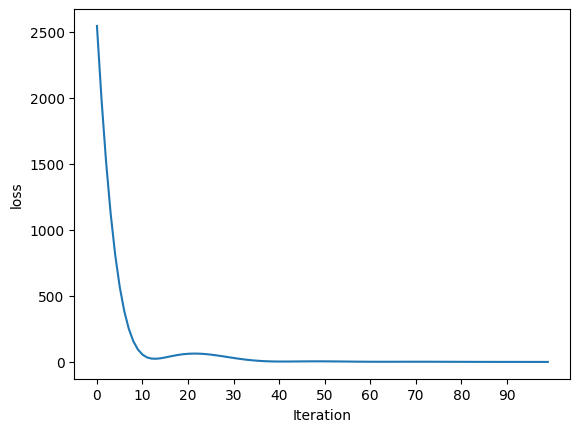

final representation:  [(' Cyprus', 51.699), (' Zimbabwe', 51.693), (' Romania', 51.497), (' Bangladesh', 51.492), (' Nigeria', 51.328)]


In [313]:
corner = corner_estimator.estimate_corner_with_gradient_descent(objects, target_logit_value=50, verbose=True)

In [314]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = relation,
    layer = 15,
    weight = torch.stack(
        [wb['weight'] for wb in weights_and_biases]
    ).mean(dim=0),
    # bias = torch.stack(
    #     [wb['bias'] for wb in weights_and_biases]
    # ).mean(dim=0),
    bias = corner,

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

In [315]:
relation_operator("The Great Wall", device = model.device)

[' China', ' Beijing', ' Taiwan', ' Russia', ' Kazakhstan']

In [316]:
from relations.evaluate import evaluate

In [317]:
precision, ret_dict = evaluate(
    relation_id = "P17",
    relation_operator = relation_operator,
    validation_set = [(c["subject"], -1, c["target_true"]["str"]) for c in counterfact_gold],
    precision_at = 3,
)

precision

validating on 407 subject --> object associations


100%|██████████| 407/407 [00:22<00:00, 17.85it/s]


0.8230958230958231

In [339]:
# h_intervention_batch = h_original_batch @ subspace + h_corruption_mean @ (I - subspace)
subspace = Q @ Q.T

weights_and_biases_subspace = get_multiple_averaged_JB(
    samples, 
    relation_prompt = relation, 
    N = 3, 
    calculate_at_lnf=False,
    subspace = (
        subspace, 
#         h_corruption_mean @ (I - subspace)
        torch.zeros(mt.n_embd).to(model.dtype).to(model.device)
    )
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

subject:  Hattfjelldal
Valdemarsvik is located in the country of Sweden.
Kyoto University is located in the country of Japan.
{} is located in the country of
tensor(80.0001, device='cuda:0') tensor(249.8445, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  Kyoto University
Niagara Falls is located in the country of Canada.
Hattfjelldal is located in the country of Norway.
{} is located in the country of
tensor(82.2312, device='cuda:0') tensor(250.2853, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  Valdemarsvik
Niagara Falls is located in the country of Canada.
Hattfjelldal is located in the country of Norway.
{} is located in the country of
tensor(44.8916, device='cuda:0') tensor(277.7527, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  Niagara Falls
Kyoto University is located in the country of Japan.
Valdemarsvik is located in the country of Sweden.
{} is located in the country of
tensor(108.2379, device='cuda:0') tensor(273.7233, d

  0%|          | 0/4 [00:00<?, ?it/s]

subject:  Ginza
Valdemarsvik is located in the country of Sweden.
The Great Wall is located in the country of China.
{} is located in the country of
tensor(68.9775, device='cuda:0') tensor(244.7100, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  Valdemarsvik
The Great Wall is located in the country of China.
Niagara Falls is located in the country of Canada.
{} is located in the country of
tensor(49.9703, device='cuda:0') tensor(276.1677, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  Niagara Falls
The Great Wall is located in the country of China.
Ginza is located in the country of Japan.
{} is located in the country of
tensor(107.8401, device='cuda:0') tensor(284.7330, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  The Great Wall
Ginza is located in the country of Japan.
Niagara Falls is located in the country of Canada.
{} is located in the country of
tensor(105.7469, device='cuda:0') tensor(261.6273, device='cuda:0', grad_fn=<Li

  0%|          | 0/4 [00:00<?, ?it/s]

subject:  Valdemarsvik
Hattfjelldal is located in the country of Norway.
The Great Wall is located in the country of China.
{} is located in the country of
tensor(46.1953, device='cuda:0') tensor(264.3004, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  Hattfjelldal
The Great Wall is located in the country of China.
Ginza is located in the country of Japan.
{} is located in the country of
tensor(79.6235, device='cuda:0') tensor(265.7157, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  The Great Wall
Ginza is located in the country of Japan.
Hattfjelldal is located in the country of Norway.
{} is located in the country of
tensor(109.3693, device='cuda:0') tensor(269.6064, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

subject:  Ginza
Valdemarsvik is located in the country of Sweden.
The Great Wall is located in the country of China.
{} is located in the country of
tensor(68.9775, device='cuda:0') tensor(244.7100, device='cuda:0', grad_fn=<Linalg

In [341]:
relation_operator_subspace = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = relation,
    layer = 15,
    weight = torch.stack(
        [wb['weight'] for wb in weights_and_biases_subspace]
    ).mean(dim=0),
    # bias = torch.stack(
    #     [wb['bias'] for wb in weights_and_biases]
    # ).mean(dim=0),
    bias = corner,
    subspace = (
        subspace, 
#         h_corruption_mean @ (I - subspace)
        torch.zeros(mt.n_embd).to(model.dtype).to(model.device)
    )

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

In [342]:
relation_operator_subspace("Taj Mahal", device = model.device)

[' India', ' Pakistan', ' Bangladesh', ' Nepal', ' Afghanistan']

In [343]:
precision, ret_dict = evaluate(
    relation_id = "P17",
    relation_operator = relation_operator_subspace,
    validation_set = [(c["subject"], -1, c["target_true"]["str"]) for c in counterfact_gold],
    precision_at = 3,
)

precision

validating on 407 subject --> object associations


100%|██████████| 407/407 [00:22<00:00, 17.85it/s]


0.8452088452088452

In [240]:
relation_operator.weight.norm(), relation_operator_subspace.weight.norm()

(tensor(18.6448, device='cuda:0'), tensor(57.5564, device='cuda:0'))

In [241]:
relation_operator.bias.norm(), relation_operator_subspace.bias.norm()

(tensor(49.3129, device='cuda:0'), tensor(49.3129, device='cuda:0'))

In [242]:
torch.stack([wb['bias'] for wb in weights_and_biases]).mean(dim=0).norm()

tensor(241.1568, device='cuda:0')

In [243]:
torch.stack([wb['bias'] for wb in weights_and_biases_subspace]).mean(dim=0).norm()

tensor(237.4820, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [245]:
relation_operator_identity = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = relation,
    layer = 15,
    weight = torch.eye(mt.n_embd).to(model.dtype).to(model.device),
    bias = corner,

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

In [246]:
precision, ret_dict = evaluate(
    relation_id = "P17",
    relation_operator = relation_operator_identity,
    validation_set = [(c["subject"], -1, c["target_true"]["str"]) for c in counterfact_gold],
    precision_at = 3,
)

precision

validating on 407 subject --> object associations


100%|██████████| 407/407 [00:22<00:00, 17.72it/s]


0.855036855036855

In [285]:
torch.zeros(mt.n_embd).to(model.dtype).to(model.device)

torch.Size([4096])

In [ ]:
r = "{} is located in the country of"

"The Space Needle" ---> h_o ----> z_o ---> "United States"
"Eiffel Tower"     ---> h_c ----> z_c ---> "France"

Q = [n_embd, low_rank = 100]
subspace = Q @ Q.T

h_i = subspace @ h_o + (I - subspace) @ h_c

"The Space Needle" ---> h_i ----> z_i ---> X = "United States"


loss = KL(ll(z_o) | ll(z_i)) + (I - Q.T @ Q).square().sum()

In [ ]:
J @ h_o + bias = z_o
J @ (subspace @ h_o + (I - subspace) @ h_avg) + corner

h_i = h_avg + subspace @ (h_o - h_avg)
norm(subspace@(h_0-h_avg))